# I. **Import library**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [15]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Declare parameters
batch_size = 64
epochs = 10
lr = 0.1
max_grad_norm = 1.2
epsilon = 1.0
delta = 1e-5

# **2. Load MNIST dataset**

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Prepare data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [18]:
# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# **3. Visualization**

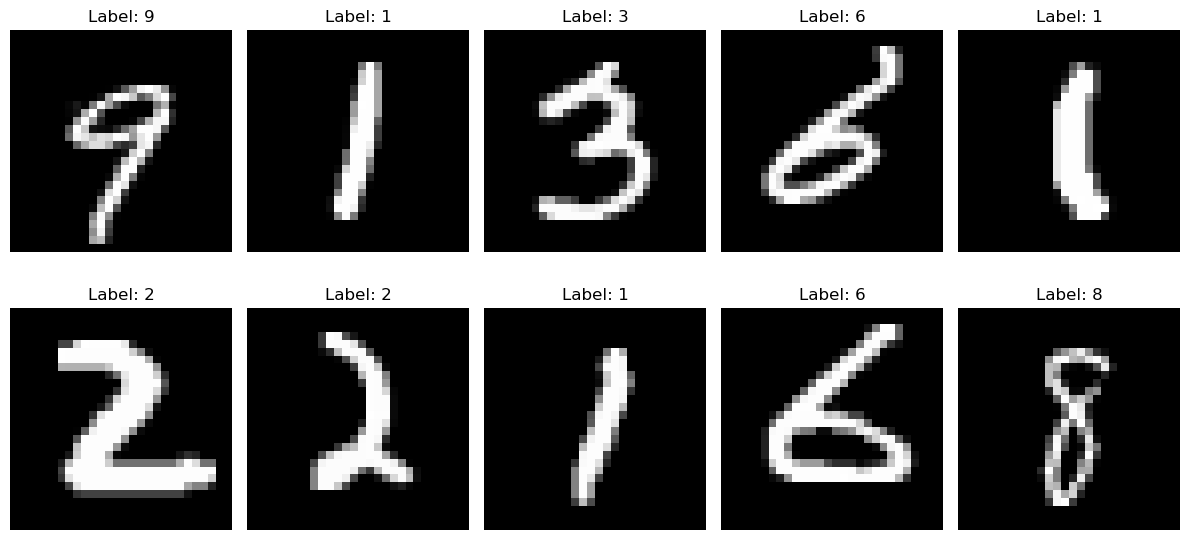

In [19]:
# Visualization
def plot_samples(loader):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, (img, label) in enumerate(loader):
        if i >= 10:
            break
        ax = axes[i//5, i%5]
        ax.imshow(img[0].squeeze(), cmap='gray')
        ax.set_title(f'Label: {label[0].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(train_loader)

# **4. Initialize Model**

In [20]:
# Define FNN model
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = FNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# **5. Configure DP-SGD**
[Opacus](https://ai.meta.com/blog/introducing-opacus-a-high-speed-library-for-training-pytorch-models-with-differential-privacy/) is a new high-speed library for training PyTorch models with differential privacy (DP) that’s more scalable than existing state-of-the-art methods. Differential privacy is a mathematically rigorous framework for quantifying the anonymization of sensitive data. It’s often used in analytics, with growing interest in the machine learning (ML) community.

Opacus provides:

- Speed: By leveraging Autograd hooks in PyTorch, Opacus can compute batched per-sample gradients, resulting in an order of magnitude speedup compared with existing DP libraries that rely on microbatching.

- Safety: Opacus uses a 
cryptographically safe pseudo-random number generator
 for its security-critical code. This is processed at high speed on the GPU for an entire batch of parameters.

- Flexibility: Thanks to PyTorch, engineers and researchers can quickly prototype their ideas by mixing and matching our code with PyTorch code and pure Python code.

- Productivity: Opacus comes with tutorials, helper functions that warn about incompatible layers before your training even starts, and automatic refactoring mechanisms.

- Interactivity: Opacus keeps track of how much of your privacy budget (a core mathematical concept in DP) you are spending at any given point in time, enabling early stopping and real-time monitoring.

<h3>Opacus Workflow</h3>
<center>
    <video controls src="./videos/Opacus_Workflow.mp4">
</center>

In [21]:
# Privacy engine
privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=epochs,
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_grad_norm,
)

d:\anaconda3_env\Lib\site-packages\opacus\privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
d:\anaconda3_env\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


# **6. Prepare train and test functions**

In [22]:
# Train model with DP
def train(model, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return sum(losses) / len(losses)

In [23]:
# Test function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return test_loss, accuracy

# **7. Train model**

In [24]:
# Train model
num_epochs = 10
train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    epsilon = privacy_engine.get_epsilon(delta=delta)
    print(f"ε: {epsilon:.2f}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332835
Train Epoch: 1 [7300/60000 (11%)]	Loss: 1.236381
Train Epoch: 1 [11200/60000 (21%)]	Loss: 0.840621
Train Epoch: 1 [21300/60000 (32%)]	Loss: 0.474037
Train Epoch: 1 [28400/60000 (43%)]	Loss: 0.811779
Train Epoch: 1 [27500/60000 (53%)]	Loss: 0.480093
Train Epoch: 1 [50400/60000 (64%)]	Loss: 0.658980
Train Epoch: 1 [35000/60000 (75%)]	Loss: 0.792365
Train Epoch: 1 [50400/60000 (85%)]	Loss: 0.680274
Train Epoch: 1 [54900/60000 (96%)]	Loss: 0.777298

Test set: Average loss: 0.0005, Accuracy: 8784/10000 (87.84%)

ε: 0.44
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.456603
Train Epoch: 2 [7900/60000 (11%)]	Loss: 0.770981
Train Epoch: 2 [11600/60000 (21%)]	Loss: 0.415457
Train Epoch: 2 [22500/60000 (32%)]	Loss: 0.289607
Train Epoch: 2 [22400/60000 (43%)]	Loss: 0.499091
Train Epoch: 2 [28000/60000 (53%)]	Loss: 0.124194
Train Epoch: 2 [37800/60000 (64%)]	Loss: 1.100277
Train Epoch: 2 [45500/60000 (75%)]	Loss: 0.652554
Train Epoch: 2 [44800/60000 (85%)]	Loss:

# **8. Display result**

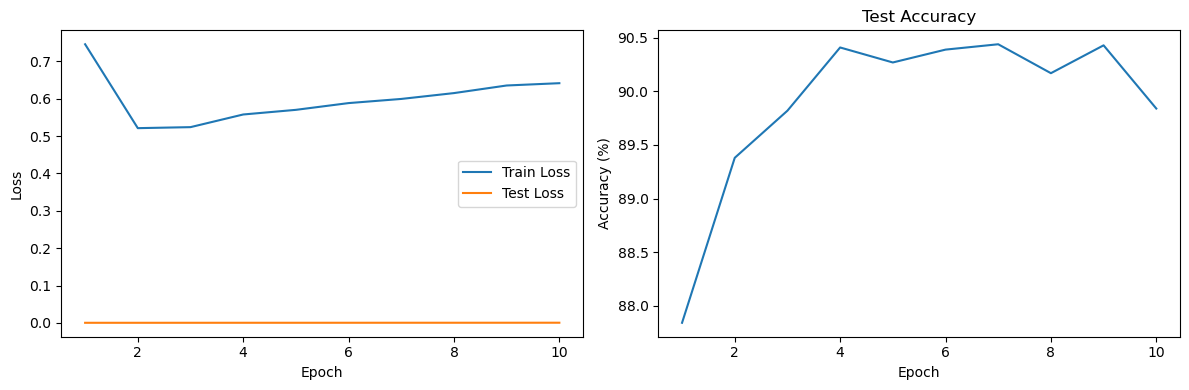

In [25]:
# Visualize resutl
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(range(1, num_epochs + 1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

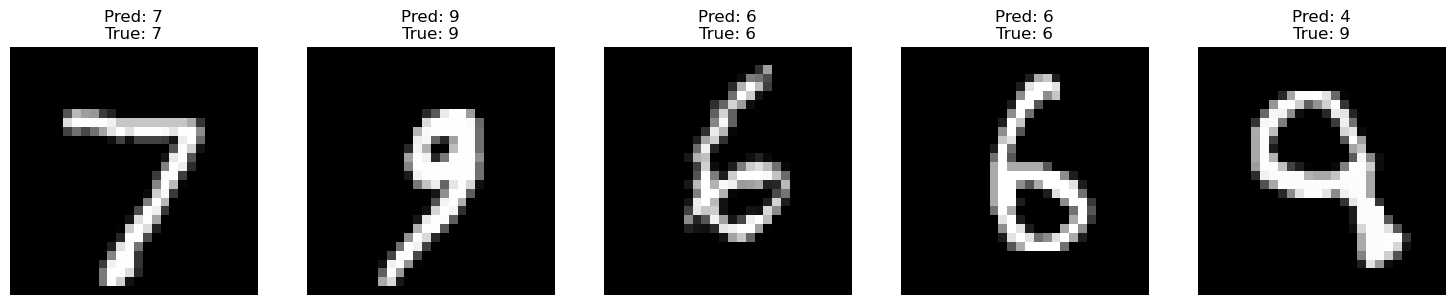

In [26]:
def visualize_predictions(model, test_loader, num_examples=5):
    model.eval()
    data_iter = iter(test_loader)
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        data, target = next(data_iter)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        img = data[0].cpu().squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Pred: {pred[0].item()}\nTrue: {target[0].item()}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)

# **9. Save model**

In [27]:
torch.save(model.state_dict(), './model_params/dp_cnn.pt')

In [ ]:
# How to load model parameters?
# state_dict = torch.load('./model_params/dp_cnn.pt')
# new_model = FNN()
# new_model.load_state_dict(state_dict=state_dict)